In [0]:
## Predicting Austin 311 Call Volume
## Jennifer Cruser, Morgan Wall, Greg Wert

In [1]:
# data processing and functions
import io
import timeit
from functools import reduce
from datetime import date
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse
import scipy as sp
import statsmodels.api as sm
import re

#analytics and modeling
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

# graphing and visualizing
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import savefig



C:\Users\student\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\student\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# functions called throughout script
from sklearn.preprocessing import MinMaxScaler
def scale(x):
    scaler = MinMaxScaler(feature_range=(0, 1)) #x_norm=(x-min)/(min-max)
    data_norm = pd.Series(scaler.fit_transform(x)[:,0],index=x.index)
    max_x = np.max(x)
    min_x = np.min(x)
    return data_norm, max_x[0], min_x[0]

def TrainTestSplit(x,trainEnd,testStart):
    train = x[:trainEnd]
    test = x[testStart:]
    return train, test

def net_Prep(data,seq_size):
    x = [data[(i+0):(i+seq_size)] for i in range(len(data)-(seq_size))]
    x = np.reshape(x,[len(x),seq_size,1])
    y = [data[(i+1):(i+seq_size+1)] for i in range(len(data)-(seq_size))]
    return x, y

def denormalize(x,minX,maxX):
    return x*(maxX-minX)+minX

def getActual(data,preds,seq_size):
    train = data[seq_size:seq_size+len(preds)]
    test  = data[2*seq_size+len(preds):]
    return train, test

def mse(pred,actual):
    m = (np.asarray([pred[i]-actual.iloc[i] for i in range(len(actual))])**2).mean()
    return m

In [3]:
# import data (if using collaboratory)
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving austin_311_service_requests.csv to austin_311_service_requests.csv
User uploaded file "austin_311_service_requests.csv" with length 171303265 bytes


In [3]:
austin_311 = pd.read_csv(io.StringIO(uploaded['austin_311_service_requests.csv'].decode('utf-8')), low_memory=False)

NameError: name 'uploaded' is not defined

In [4]:
# if loaded locally
austin_311 = pd.read_csv('austin_311_service_requests.csv', low_memory=False)

## Data Cleaning

In [5]:
austin_311.head()

,city,close_date,complaint_description,complaint_type,council_district_code,county,created_date,incident_address,incident_zip,last_update_date,...,map_tile,owning_department,source,state_plane_x_coordinate,state_plane_y_coordinate,status,status_change_date,street_name,street_number,unique_key
0,AUSTIN,2015-01-20 10:41:48,Loose Dog,ACLONAG,3.0,TRAVIS,2015-01-20 10:41:48,1305 CORIANDER DR AUSTIN TX,78741.0,2015-01-27 12:51:06,...,ML18,Animal Services Office,Phone,3131141.68710771,1.005532e+07,Duplicate (closed),2015-01-20 10:41:48,CORIANDER,1305.0,15-00012439
1,AUSTIN,2016-06-01 10:58:13,Loose Dog,ACLONAG,7.0,TRAVIS,2016-05-22 10:00:49,3104 STONEWAY DR AUSTIN TX 78757,78757.0,2016-06-01 09:58:30,...,MJ29,Animal Services Office,Phone,3112134.24930453,1.010083e+07,Closed,2016-06-01 10:58:13,STONEWAY,3104.0,16-00123310
2,AUSTIN,2014-01-06 19:30:00,Loose Animal (not dog),ACLOANIM,2.0,TRAVIS,2014-01-06 18:04:00,4100 SMITH SCHOOL RD AUSTIN TX,78744.0,2014-01-06 18:32:00,...,MK16,Animal Services Office,Phone,3124825.4024878,1.004597e+07,Closed,2014-01-06 19:30:00,SMITH SCHOOL,4100.0,14-00003554
3,AUSTIN,2014-11-19 10:46:48,Austin Code - Request Code Officer,CODECOMP,7.0,TRAVIS,2014-11-15 15:43:41,12710 PALFREY DR AUSTIN TX 78727,78727.0,2014-11-19 10:46:48,...,ML35,Austin Code Department,Web,3124206.25,1.012812e+07,Closed,2014-11-19 10:46:48,PALFREY,12710.0,14-00247505
4,AUSTIN,2014-08-25 21:21:00,Animal - Proper Care,ACPROPER,1.0,TRAVIS,2014-07-28 17:33:00,6703 TULANE DR AUSTIN TX,78723.0,2014-08-25 20:23:00,...,MM26,Animal Services Office,Phone,3137129.998,1.008721e+07,Closed,2014-08-25 21:21:00,TULANE,6703.0,14-00156342


In [6]:
austin_311.shape

(463540, 24)

In [7]:
# look at data types
austin_311.dtypes

city                         object
close_date                   object
complaint_description        object
complaint_type               object
council_district_code       float64
county                       object
created_date                 object
incident_address             object
incident_zip                float64
last_update_date             object
latitude                    float64
location                     object
longitude                   float64
map_page                     object
map_tile                     object
owning_department            object
source                       object
state_plane_x_coordinate     object
state_plane_y_coordinate    float64
status                       object
status_change_date           object
street_name                  object
street_number               float64
unique_key                   object
dtype: object

In [8]:
#update incorrect data types
austin_311['close_date'] = pd.to_datetime(austin_311['close_date'], format = "%Y-%m-%d")
austin_311['created_date'] = pd.to_datetime(austin_311['created_date'], format = "%Y-%m-%d")
austin_311['last_update_date'] = pd.to_datetime(austin_311['last_update_date'], format = "%Y-%m-%d")
austin_311['status_change_date'] = pd.to_datetime(austin_311['status_change_date'], format = "%Y-%m-%d")

#austin_311['state_plane_x_coordinate'] = pd.to_numeric(austin_311['state_plane_x_coordinate'])

In [9]:
# look at null values
austin_311.isnull().sum()
#austin_311_clean = austin_311.dropna(axis = 1, thresh = (35211-5000))

city                         8558
close_date                  35211
complaint_description        4235
complaint_type               4235
council_district_code       30202
county                      10793
created_date                10799
incident_address             7925
incident_zip                 8577
last_update_date            10799
latitude                     7999
location                     7999
longitude                    7999
map_page                     8607
map_tile                     9527
owning_department            4235
source                       4235
state_plane_x_coordinate     7986
state_plane_y_coordinate     8029
status                       4235
status_change_date          10799
street_name                  8005
street_number               96669
unique_key                   4234
dtype: int64

In [10]:
# look at the number of calls from austin
austin_311.groupby(['city']).size()

city
AUST                     1
AUSTIN              443258
AUSTIN 5 ETJ          1217
AUSTN                   22
AUsti                    1
AUstin                   4
AuStin                   2
Aus                      2
Ausitn                   1
Aust                     1
AustIn                   3
AustiN                   4
Austin                 710
Austin.                  2
Austn                    1
Austtin                  1
BASTROP                 17
BEAR CREEK               2
BEE CAVE               237
BRIARCLIFF              59
BUDA                   107
Buda                     1
CEDAR CREEK             36
CEDAR PARK             467
COUPLAND                34
CREEDMOOR               76
Cedar park               2
DALLAS                   1
DEL VALLE             1835
DRIPPING SPRIN          15
                     ...  
SPICEWOOD              118
SUNSET VALLEY          204
Sealy                    1
TERRBONNE                1
THE HILLS               22
TRAVIS                 

In [11]:
# fix the austin typos and drop other cities
austin_311.loc[austin_311['city'] == 'AUST', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'AUSTIN 5 ETJ', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'AUSTN', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'AUstin', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'AuStin', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'Aus', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'Ausitn', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'Aust', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'AustIn', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'AustiN', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'Austin.', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'Austn', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'Austtin', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'AUsti', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'Austin', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'aUSTIN', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'aus', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'ausitn', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'austi', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'austibn', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'austin', 'city'] = 'AUSTIN'
austin_311.loc[austin_311['city'] == 'austn', 'city'] = 'AUSTIN'
#re.sub('AUST'|'AUSTIN 5 ETJ'| 'AUSTN'|'AUsti'|'AuStin'|'Aus'|'Ausitn'|'Aust'|'AustIn'|'AustiN'|'Austin.'|'Austn'|'Austtin'|'AUsti'| 'Austin'| 'aUSTIN'|'aus'|'ausitn'|'austi'|' austibn'|'austin'|'austn', 'AUSTIN', austin_311['city'])

In [12]:
# Keep on the Austin rows
austin_311 = austin_311[austin_311.city == 'AUSTIN']

In [13]:
# looking at top complaints
top_complaints = austin_311.groupby(['complaint_type'])['complaint_type'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False).head(10).reset_index()

top_complaints

C:\Users\student\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,complaint_type,code_count
0,CODECOMP,76403
1,ACLONAG,28851
2,TRASIGMA,28391
3,SWSRECYC,21348
4,SWSDEADA,20472
5,ACINFORM,19210
6,STREETL2,18052
7,HHSGRAFF,17264
8,COAACINJ,14201
9,SWSYARDT,13625


In [14]:
# new dataframe of only created data and city
austin_date = pd.DataFrame(austin_311[['created_date', 'city']])
austin_date.shape

(445886, 2)

In [15]:
# set date as index
austin_date.set_index(["created_date"],inplace=True)

In [16]:
#group by day, week and month
austin_day = austin_date.resample('D').count()
austin_week = austin_date.resample('W').count()
austin_month = austin_date.resample('M').count()

In [17]:
austin_week.head()

,city
created_date,
2014-01-05,942
2014-01-12,1914
2014-01-19,2176
2014-01-26,1872
2014-02-02,1878


In [18]:
#check for null values
austin_week[austin_week['city'].isnull()].index.tolist()

[]

In [19]:
#rename city to calls
austin_week.columns = ['calls']
austin_day.columns = ['calls']
austin_month.columns = ['calls']

## Data Exploration

Text(0.5,1,'Austin 311 Calls')

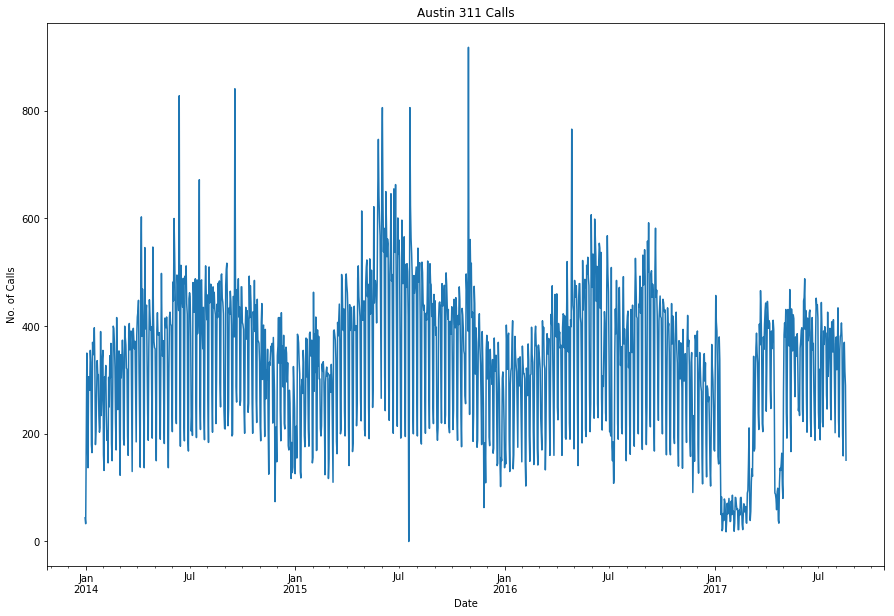

In [20]:
# Should plot total volume of calls over time 
plt.figure(figsize = (15,10))


austin_day.calls.plot()
plt.xlabel('Date')
plt.ylabel('No. of Calls')
plt.title("Austin 311 Calls")

Text(0.5,1,'Austin 311 Calls Per Week')

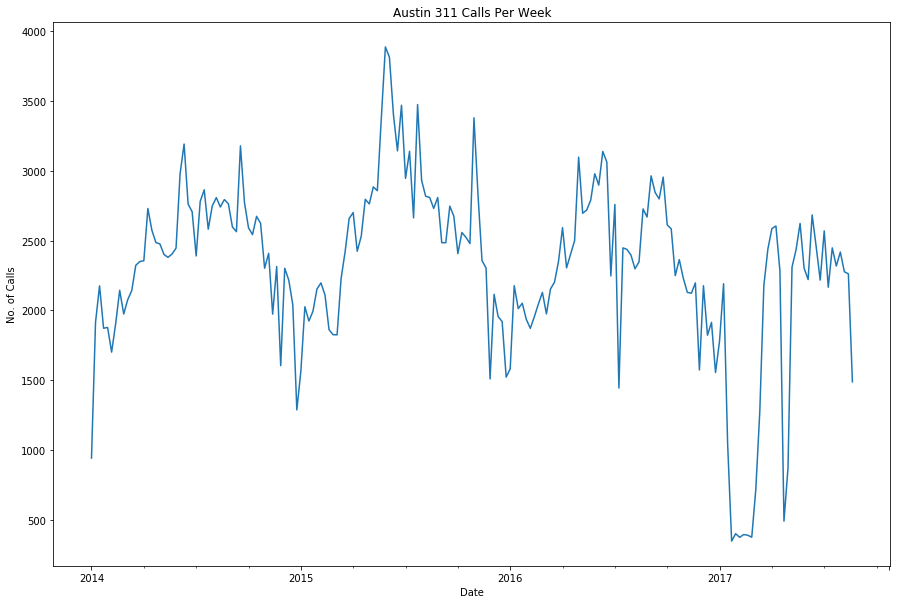

In [21]:
# Should plot total volume of calls over time 
plt.figure(figsize = (15,10))


austin_week.calls.plot()
plt.xlabel('Date')
plt.ylabel('No. of Calls')
plt.title("Austin 311 Calls Per Week")

**ARIMA model with Weekly Data**

Text(0.5,1,'Austin 311 Residuals')

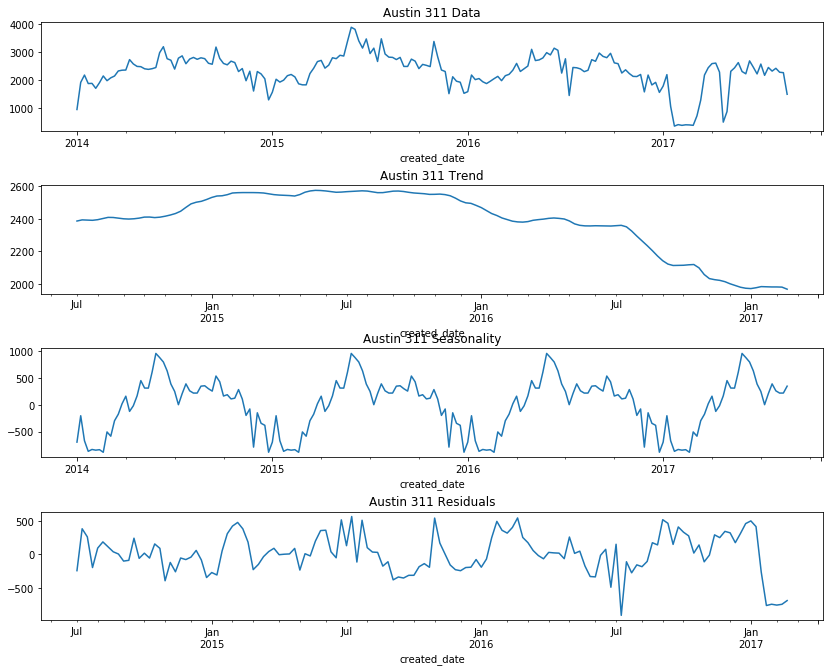

In [22]:
# Decomposing the elements of the time series


from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(austin_week.calls, freq = 52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid



fig = plt.figure(figsize = (14,11))
plt.subplots_adjust(hspace = .5)

ts = fig.add_subplot(4, 1, 1)
austin_week.calls.plot()
ts.set_title("Austin 311 Data")
ts_trend = fig.add_subplot(4,1,2)
trend.plot()
ts_trend.set_title('Austin 311 Trend')
ts_seasonal = fig.add_subplot(4,1,3)
seasonal.plot()
ts_seasonal.set_title('Austin 311 Seasonality')
ts_residual = fig.add_subplot(4,1,4)
residual.plot()
ts_residual.set_title('Austin 311 Residuals')

#plotted data
#overall trend over time
#seasonal fluctuations
#what can't be attributed to trend or seasonal

Text(0.5,0,'Years')

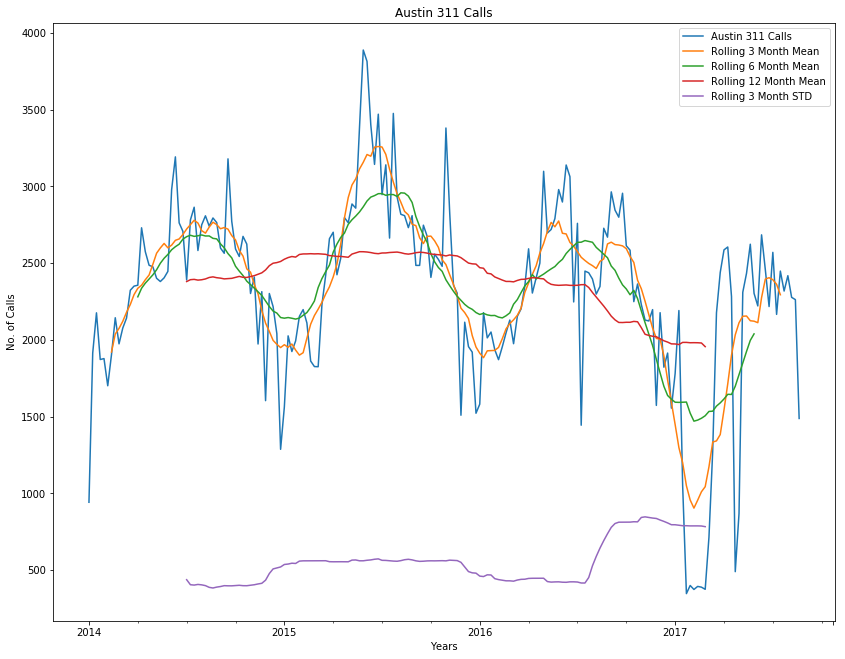

In [23]:
# Filters - Moving Averages

# Plot moving (rolling) averages at 3, 6 and 12 months.
# Also plot the standard deviation for 3 months


fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
austin_week.calls.plot(label = 'Austin 311 Calls')
austin_week.calls.rolling(window =  12, center = True).mean().plot(label = 'Rolling 3 Month Mean')
austin_week.calls.rolling(window =  26, center = True).mean().plot(label = 'Rolling 6 Month Mean')
austin_week.calls.rolling(window =  52, center = True).mean().plot(label = 'Rolling 12 Month Mean')
austin_week.calls.rolling(window =  52, center = True).std().plot(label = 'Rolling 3 Month STD')

ts.legend(loc = 'best')
ts.set_title("Austin 311 Calls")
ts.set_ylabel("No. of Calls")
ts.set_xlabel("Years")


In [24]:
# Dickey-Fuller test of stationarity
# 

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    # Null hypothesis is that the data are non-stationary
    print ('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

In [25]:
# Test data for stationarity

test_stationarity(austin_week['calls'])
#shows that the data is stationary enough to do the ARIMA

Dickey-Fuller Test:
Test Statistic                  -3.763404
p-value                          0.003305
#Lags Used                       1.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


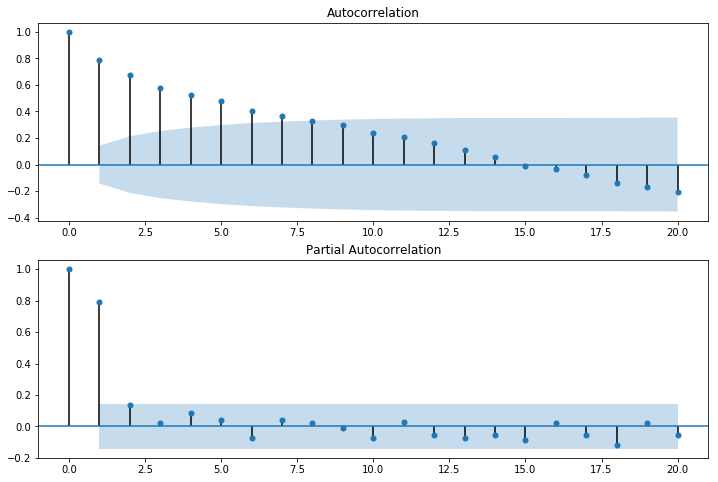

In [26]:

# Autocorrelation and partial autocorrelations for the call data.

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(austin_week['calls'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(austin_week['calls'], lags=20, ax=ax2)
#might need to experiment with the lags here a bit more

In [27]:
# Frequency Domain
# Graphs of the FFT give the periordogram which plots power vs. frequency
# allows you to show the periodicity, frequencies in complex systems boundary 
# conditions does a lot of good estimations have to worry about the boundaries, will have to spend a lot of time fixing 

calls_fft = sp.fftpack.fft(austin_week['calls'])
calls_psd = np.abs(calls_fft)**2


In [28]:
# Filter by positive frequencies

calls_fftfreq = sp.fftpack.fftfreq(len(calls_psd), 1/12)
i = calls_fftfreq > 0 

Text(0.5,1,'Spectral Density of Austin 311 calls')

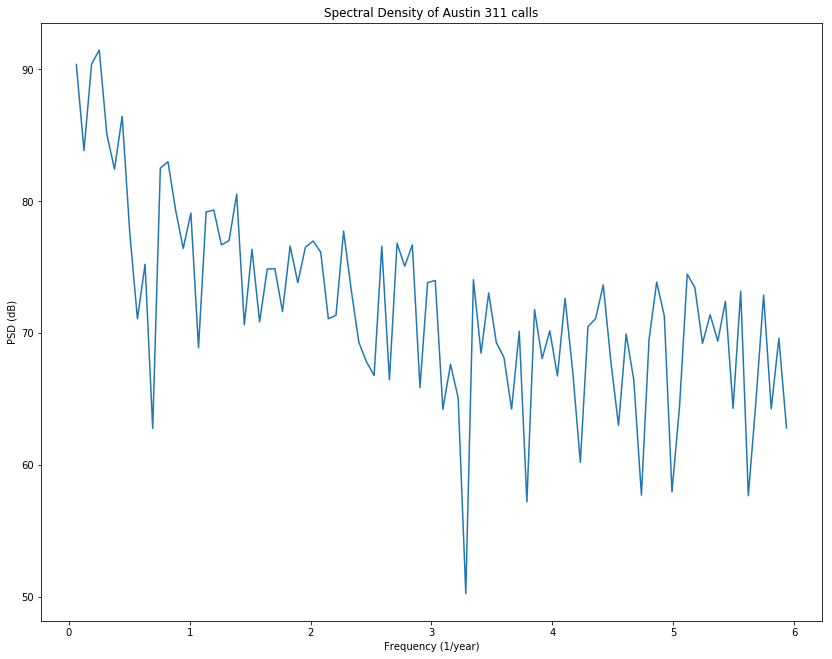

In [29]:
# Plot the Periodogram and find the frequencies

plt.figure(figsize = (14,11))
plt.plot(calls_fftfreq[i], 10*np.log10(calls_psd[i]))
#plt.xlim(0,5)
plt.xlabel('Frequency (1/year)')
plt.ylabel('PSD (dB)')
plt.title('Spectral Density of Austin 311 calls')

In [30]:
# Remove all frequencies that are harmonics
# Invert the FFT to get a model of the time series
# Use only the real part

calls_fft_bis = calls_fft.copy() # get a copy
calls_fft_bis[np.abs(calls_fftfreq > 1.1)] = 0 # remove harmonics
calls_freqfit = np.real(sp.fftpack.ifft(calls_fft_bis)) #invert fft
calls_freqfit = pd.Series(calls_freqfit, index = austin_week.index)

Text(0,0.5,'No. of Calls')

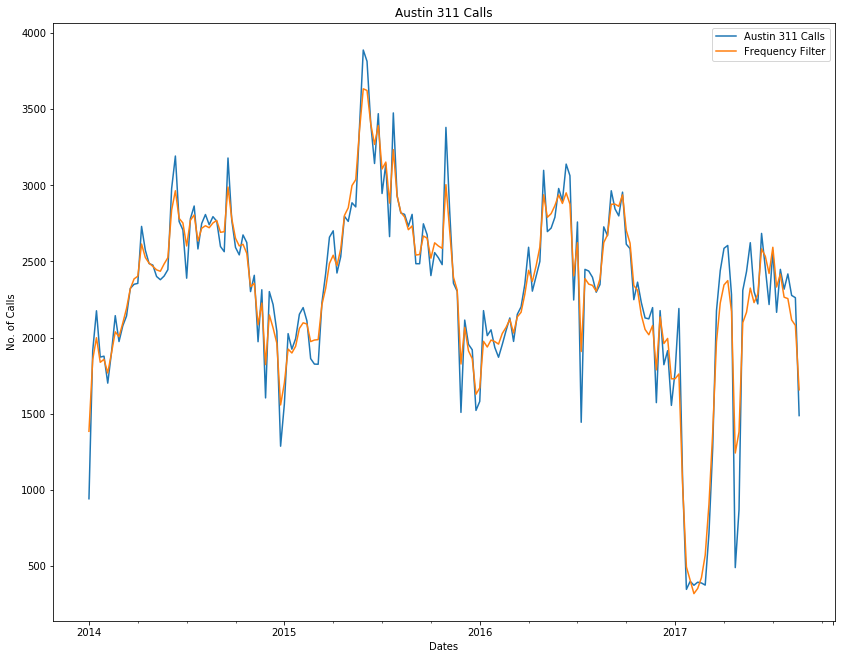

In [31]:
# 
# Then plot on the original series
# with the frequency model

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
austin_week['calls'].plot(label = 'Austin 311 Calls')
calls_freqfit.plot(label = 'Frequency Filter')

ts.legend(loc = 'best')
ts.set_title("Austin 311 Calls")
plt.xlabel('Dates')
plt.ylabel('No. of Calls')

## Basic ARIMA

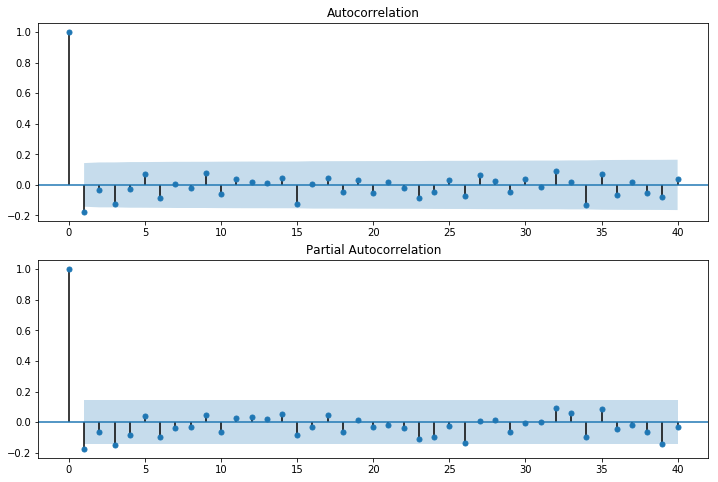

In [33]:
# ARIMA Models
# Model 1
# First difference (monthly)

CallsDiff1 = austin_week['calls'].diff(1)

# Look at ACF, PACF

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(CallsDiff1.dropna(inplace = False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(CallsDiff1.dropna(inplace = False), lags=40, ax=ax2)

In [34]:
mod1 = ARIMA(austin_week['calls'].astype(float), order=(1, 0, 1))  
results = mod1.fit()
print (results.summary())

C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                  calls   No. Observations:                  190
Model:                     ARMA(1, 1)   Log Likelihood               -1391.599
Method:                       css-mle   S.D. of innovations            365.887
Date:                Wed, 02 May 2018   AIC                           2791.198
Time:                        14:19:54   BIC                           2804.186
Sample:                    01-05-2014   HQIC                          2796.459
                         - 08-20-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2255.7706    159.986     14.100      0.000    1942.204    2569.338
ar.L1.calls     0.8593      0.047     18.315      0.000       0.767       0.951
ma.L1.calls    -0.1319      0.094     -1.401    

C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


139984.40583957214


Text(0.5,0,'Years')

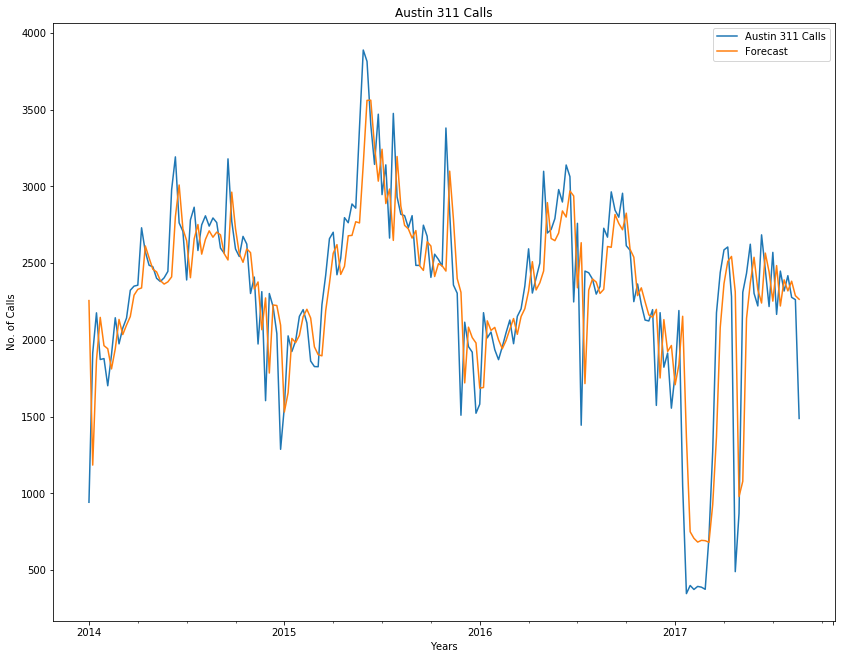

In [36]:
# Get the forecast

mod1_fitted = mod1.fit(disp=-1)  
forecast_mod1 = mod1_fitted.fittedvalues #+ austin_week.calls.mean() 
forcast_mod1_mse = mse(austin_week[forecast_mod1.index[0]:]['calls'],forecast_mod1)
print(forcast_mod1_mse)

# Plot Forecast

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
austin_week.calls.plot(label = 'Austin 311 Calls')
forecast_mod1.plot(label = 'Forecast')

ts.legend(loc = 'best')
ts.set_title("Austin 311 Calls")
ts.set_ylabel("No. of Calls")
ts.set_xlabel("Years")


## ARIMA with Daily Data

In [37]:
#check for null values
austin_day[austin_day['calls'].isnull()].index.tolist()

[]

Text(0.5,1,'Austin 311 Calls Per Day')

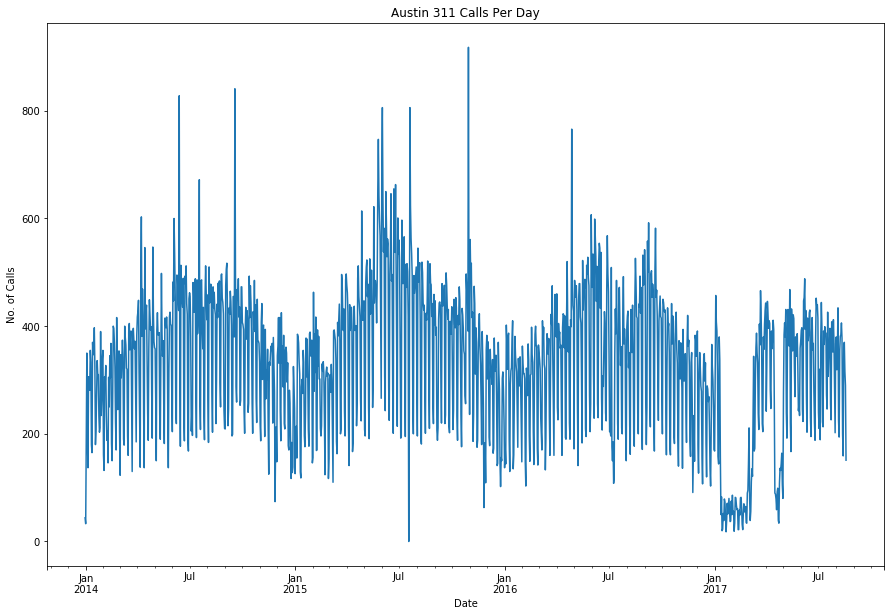

In [38]:
# Total Volume of Calls per Day
plt.figure(figsize = (15,10))


austin_day.calls.plot()
plt.xlabel('Date')
plt.ylabel('No. of Calls')
plt.title("Austin 311 Calls Per Day")

Text(0.5,1,'Austin 311 Residuals')

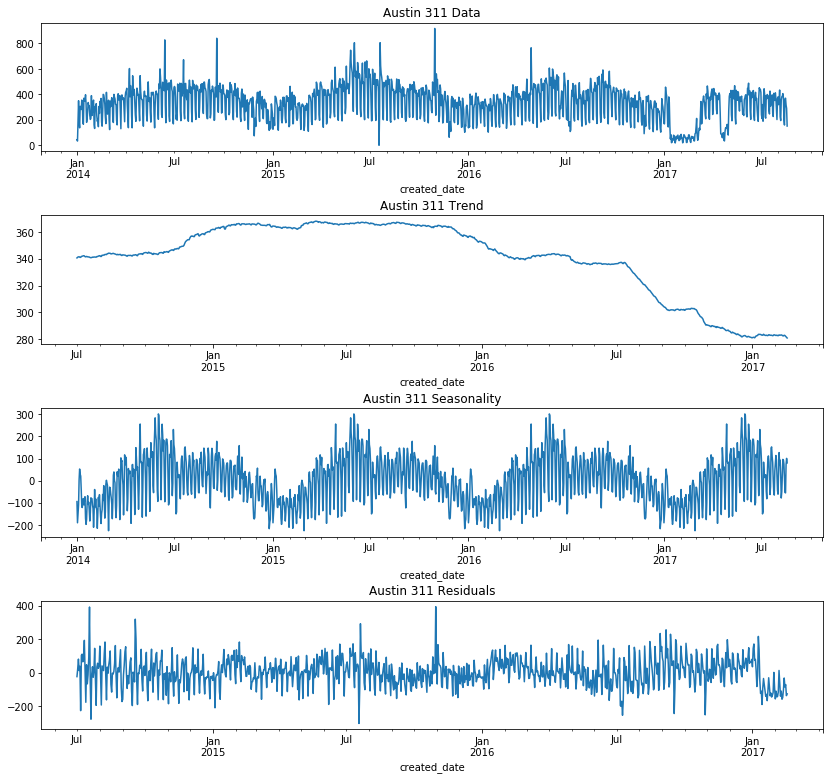

In [39]:
# Decomposing the elements of the time series


from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(austin_day.calls, freq = 365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid



fig = plt.figure(figsize = (14,13))
plt.subplots_adjust(hspace = .5)

ts = fig.add_subplot(4, 1, 1)
austin_day.calls.plot()
ts.set_title("Austin 311 Data")
ts_trend = fig.add_subplot(4,1,2)
trend.plot()
ts_trend.set_title('Austin 311 Trend')
ts_seasonal = fig.add_subplot(4,1,3)
seasonal.plot()
ts_seasonal.set_title('Austin 311 Seasonality')
ts_residual = fig.add_subplot(4,1,4)
residual.plot()
ts_residual.set_title('Austin 311 Residuals')

#plotted data
#overall trend over time
#seasonal fluctuations
#what can't be attributed to trend or seasonal

Text(0.5,0,'Years')

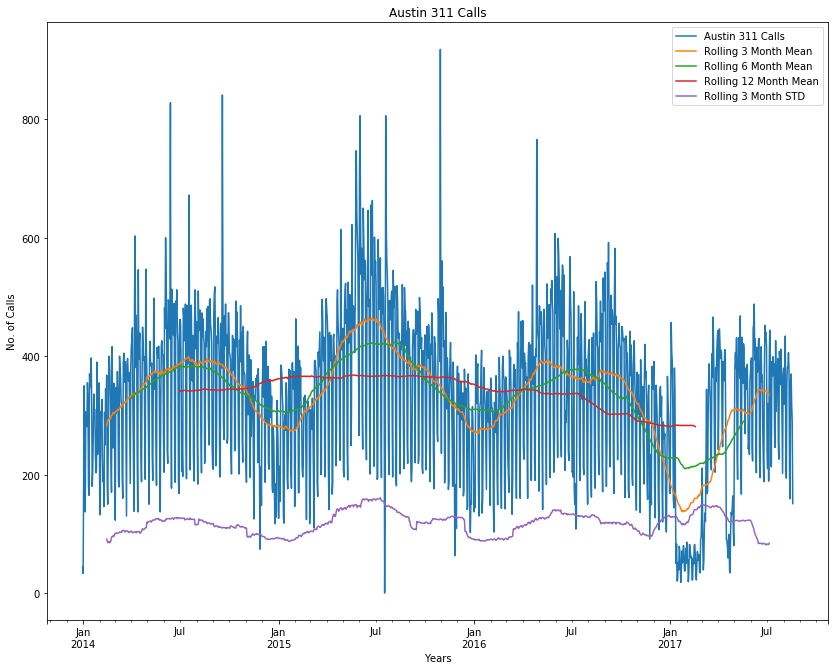

In [40]:
# Filters - Moving Averages

# Plot moving (rolling) averages at 3, 6 and 12 months.
# Also plot the standard deviation for 3 months


fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
austin_day.calls.plot(label = 'Austin 311 Calls')
austin_day.calls.rolling(window =  90, center = True).mean().plot(label = 'Rolling 3 Month Mean')
austin_day.calls.rolling(window =  183, center = True).mean().plot(label = 'Rolling 6 Month Mean')
austin_day.calls.rolling(window =  365, center = True).mean().plot(label = 'Rolling 12 Month Mean')
austin_day.calls.rolling(window =  90, center = True).std().plot(label = 'Rolling 3 Month STD')

ts.legend(loc = 'best')
ts.set_title("Austin 311 Calls")
ts.set_ylabel("No. of Calls")
ts.set_xlabel("Years")


In [41]:
# Dickey-Fuller test of stationarity

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    # Null hypothesis is that the data are non-stationary
    print ('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

In [42]:
# Test data for stationarity

test_stationarity(austin_day['calls'])
#shows that the data is stationary enough to do the ARIMA

Dickey-Fuller Test:
Test Statistic                   -3.413332
p-value                           0.010513
#Lags Used                       22.000000
Number of Observations Used    1304.000000
Critical Value (1%)              -3.435375
Critical Value (5%)              -2.863759
Critical Value (10%)             -2.567951
dtype: float64


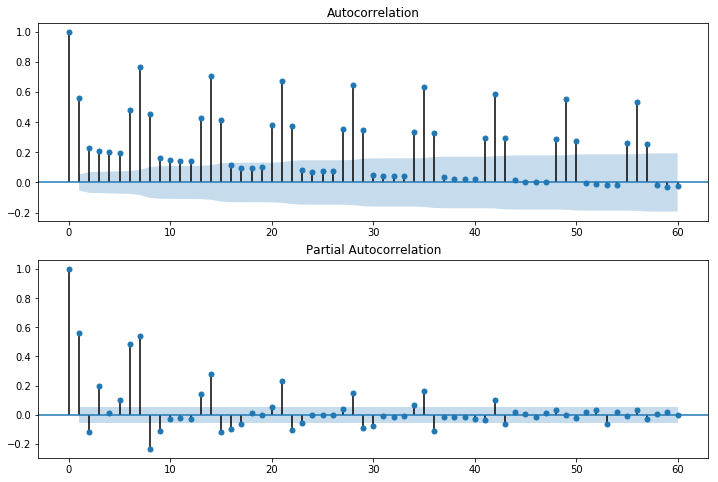

In [43]:

# Autocorrelation and partial autocorrelations for the call data.

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(austin_day['calls'], lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(austin_day['calls'], lags=60, ax=ax2)
# looks like day of the week matters

Dickey-Fuller Test:
Test Statistic                -8.274065e+00
p-value                        4.708118e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.297000e+03
Critical Value (1%)           -3.435402e+00
Critical Value (5%)           -2.863771e+00
Critical Value (10%)          -2.567958e+00
dtype: float64
None


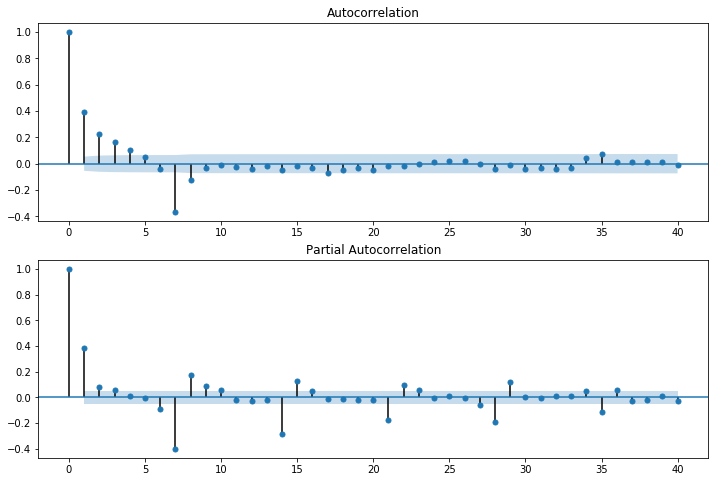

In [44]:
# Difference Filtering


CallsDiff_7 = austin_day['calls'].diff(7)
print(test_stationarity(CallsDiff_7.dropna(inplace = False)))
# Look at ACF, PACF

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(CallsDiff_7.dropna(inplace = False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(CallsDiff_7.dropna(inplace = False), lags=40, ax=ax2)

In [45]:
# Create a model using the adjusted data with an order of 4 for the autoregression, based on the significant lags from the ACF plot, and an order of 6 for the moving averages based on the PACF plot. 
mod_new = ARIMA(CallsDiff_7.dropna(inplace = False), order=(4, 0, 6))
results = mod_new.fit()
print (results.summary())

C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                  calls   No. Observations:                 1320
Model:                     ARMA(4, 6)   Log Likelihood               -7397.022
Method:                       css-mle   S.D. of innovations             65.425
Date:                Wed, 02 May 2018   AIC                          14818.044
Time:                        14:21:13   BIC                          14880.268
Sample:                    01-07-2014   HQIC                         14841.373
                         - 08-18-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.1712      5.174      0.613      0.540      -6.970      13.312
ar.L1.calls    -0.5468      0.033    -16.799      0.000      -0.611      -0.483
ar.L2.calls    -0.3905      0.037    -10.486    

C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `fl

20788.163053799126


Text(0.5,0,'Years')

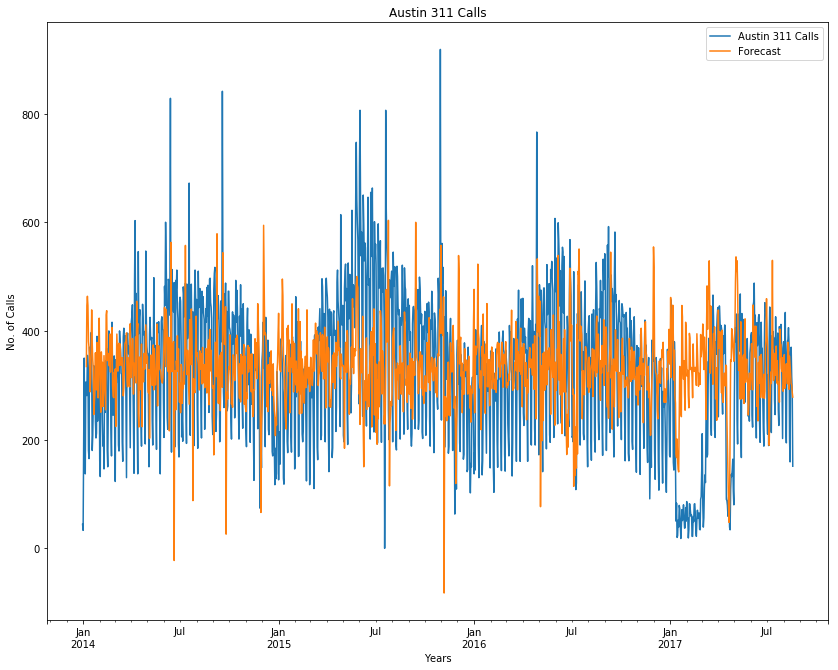

In [47]:
# Get the forecast and Plot

modnew_fitted = mod_new.fit(disp=-1)  
forecast_mod_new = modnew_fitted.fittedvalues + austin_day.calls.mean() 
forcast_mod_new_mse = mse(austin_day[forecast_mod_new.index[0]:]['calls'],forecast_mod_new)
print(forcast_mod_new_mse)
# Plot Forecast

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
austin_day.calls.plot(label = 'Austin 311 Calls')
forecast_mod_new.plot(label = 'Forecast')

ts.legend(loc = 'best')
ts.set_title("Austin 311 Calls")
ts.set_ylabel("No. of Calls")
ts.set_xlabel("Years")

## Other ARIMA models

In [48]:
mod1 = ARIMA(austin_day['calls'].astype(float), order=(7, 1, 2))  
results = mod1.fit()
print (results.summary())

C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\student\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                D.calls   No. Observations:                 1326
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -7628.869
Method:                       css-mle   S.D. of innovations             76.133
Date:                Wed, 02 May 2018   AIC                          15279.738
Time:                        14:24:47   BIC                          15336.828
Sample:                    01-01-2014   HQIC                         15301.137
                         - 08-18-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0760      0.617      0.123      0.902      -1.133       1.285
ar.L1.D.calls    -0.2281      0.086     -2.668      0.008      -0.396      -0.061
ar.L2.D.calls    -0.4366      0.071     

In [0]:
# Get the forecast and Plot

mod1_fitted = mod1.fit(disp=-1)  
forecast_mod1 = mod1_fitted.fittedvalues + austin_day.calls.mean() 

# Plot Forecast

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
austin_day.calls.plot(label = 'Austin 311 Calls')
forecast_mod1.plot(label = 'Forecast')

ts.legend(loc = 'best')
ts.set_title("Austin 311 Calls")
ts.set_ylabel("No. of Calls")
ts.set_xlabel("Years")

In [0]:
# ARIMA Models
# Model 2
# 30 day lag

CallsDiff_30 = austin_day['calls'].diff(30)
print(test_stationarity(CallsDiff_30.dropna(inplace = False)))
# Look at ACF, PACF

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(CallsDiff_28.dropna(inplace = False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(CallsDiff_28.dropna(inplace = False), lags=40, ax=ax2)

In [0]:
mod2 = ARIMA(CallsDiff_28.dropna(inplace = False).astype(float), order=(0, 1, 2))  
results = mod2.fit()
print (results.summary())

In [0]:
# Get the forecast and Plot

mod2_fitted = mod2.fit(disp=-1)  
forecast_mod3 = mod2_fitted.fittedvalues + austin_day.calls.mean() 

# Plot Forecast

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
austin_day.calls.plot(label = 'Austin 311 Calls')
forecast_mod3.plot(label = 'Forecast')

ts.legend(loc = 'best')
ts.set_title("Austin 311 Calls")
ts.set_ylabel("No. of Calls")
ts.set_xlabel("Years")

## Neural Nets

In [0]:
day, day_max, day_min = scale(austin_day)
week, week_max, week_min = scale(austin_week)
month, month_max, month_min = scale(austin_month)

In [0]:
# day data with past 30 day info
x_t, y_t = net_Prep(day,30)

In [0]:

# Encapsulate the entire prediction problem as a function
def build_and_predict(trainX,trainY,testX,seq_size,cell,cellType,max_itr,input_dim,hidden_dim):

    graph = tf.Graph()
    with graph.as_default():
        # input place holders
        # input Shape: [# training examples, sequence length, # features]
        x = tf.placeholder(tf.float32,[None,seq_size,input_dim])
        # label Shape: [# training examples, sequence length]
        y = tf.placeholder(tf.float32,[None,seq_size])
        
        
        
        # RNN output Shape: [# training examples, sequence length, # hidden] 
        outputs, _ = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)
        
        
        # weights for output dense layer (i.e., after RNN)
        # W shape: [# hidden, 1]
        W_out = tf.Variable(tf.random_normal([hidden_dim,1]),name="w_out") 
        # b shape: [1]
        b_out = tf.Variable(tf.random_normal([1]),name="b_out")
    
        # output dense layer:
        num_examples = tf.shape(x)[0] 
        # convert W from [# hidden, 1] to [# training examples, # hidden, 1]
        # step 1: add a new dimension at index 0 using tf.expand_dims
        w_exp= tf.expand_dims(W_out,0)
        # step 2: duplicate W for 'num_examples' times using tf.tile
        W_repeated = tf.tile(w_exp,[num_examples,1,1])
        
        # Dense Layer calculation: 
        # [# training examples, sequence length, # hidden] *
        # [# training examples, # hidden, 1] = [# training examples, sequence length]
        
        y_pred = tf.matmul(outputs,W_repeated)+b_out
        # Actually, y_pred: [# training examples, sequence length, 1]
        # Remove last dimension using tf.squeeze
        y_pred = tf.squeeze(y_pred)
        
        # Cost & Training Step
        cost = tf.reduce_mean(tf.square(y_pred-y))
        train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
        
        # Run Session
    with tf.Session(graph=graph) as sess:
        # initialize variables
        sess.run(tf.global_variables_initializer())
        # Run for 1000 iterations (1000 is arbitrary, need a validation set to tune!)
        start=timeit.default_timer()
        print('Training %s ...'%cellType)
        for i in range(max_itr): # If we train more, would we overfit? Try 10000
            _, train_err = sess.run([train_op,cost],feed_dict={x:trainX,y:trainY})
            if i==0:
                print('  step, train err= %6d: %8.5f' % (0,train_err)) 
            elif  (i+1) % 100 == 0: 
                print('  step, train err= %6d: %8.5f' % (i+1,train_err)) 
        end=timeit.default_timer()        
        print("Training time : %10.5f"%(end-start))
         # Test trained model on training data
        predicted_vals_all= sess.run(y_pred,feed_dict={x:testX}) 
        # Get last item in each predicted sequence:
        predicted_vals = predicted_vals_all[:,seq_size-1]
      
    
    return predicted_vals

**Exploring models**

In [0]:
# Different RNN Cell Types
hidden_dim =100
RNNcell = rnn.BasicRNNCell(hidden_dim)
LSTMcell = rnn.BasicLSTMCell(hidden_dim)
GRUcell = rnn.GRUCell(hidden_dim)


# Build models and predict on testing data
predicted_vals_rnn  =build_and_predict(x_t,y_t,x_t,30,RNNcell,"RNN",1000,1,100)
predicted_vals_lstm =build_and_predict(x_t,y_t,x_t,30,LSTMcell,"LSTM",1000,1,100)
predicted_vals_gru  =build_and_predict(x_t,y_t,x_t,30,GRUcell,"GRU",1000,1,100)

In [0]:
#----Use 2 week seq-size

# Different RNN Cell Types
RNNcell = rnn.BasicRNNCell(hidden_dim)
LSTMcell = rnn.BasicLSTMCell(hidden_dim)
GRUcell = rnn.GRUCell(hidden_dim)


# Build models and predict on testing data 

x_t14, y_t14 = net_Prep(day,14)
predicted_vals_rnn14 =build_and_predict(x_t14,y_t14,x_t14,14,RNNcell,"RNN",1000,1,100)
predicted_vals_lstm14 =build_and_predict(x_t14,y_t14,x_t14,14,LSTMcell,"LSTM",1000,1,100)
predicted_vals_gru14  =build_and_predict(x_t14,y_t14,x_t14,14,GRUcell,"GRU",1000,1,100)

In [0]:
RNNcell = rnn.BasicRNNCell(hidden_dim)
LSTMcell = rnn.BasicLSTMCell(hidden_dim)
GRUcell = rnn.GRUCell(hidden_dim)

###------- Use 1 week seq-size
x_t7, y_t7 = net_Prep(day, 7)
predicted_vals_rnn7  =build_and_predict(x_t7,y_t7,x_t7, 7, RNNcell,"RNN",1000,1,100)
predicted_vals_lstm7 =build_and_predict(x_t7,y_t7,x_t7, 7, LSTMcell,"LSTM",1000,1,100)
predicted_vals_gru7  =build_and_predict(x_t7,y_t7,x_t7, 7, GRUcell,"GRU",1000,1,100)

In [0]:
seq_size = 30
# Compute MSE
# step 1: denormalize data
predicted_vals_dnorm_rnn =predicted_vals_rnn*(day_max-day_min)+day_min
predicted_vals_dnorm_lstm=predicted_vals_lstm*(day_max-day_min)+day_min
predicted_vals_dnorm_gru =predicted_vals_gru*(day_max-day_min)+day_min
# step 2: get ground-truth
actual=np.asarray(austin_day[seq_size:])
# step 3: compute MSE
mse_rnn  = (np.asarray([predicted_vals_dnorm_rnn[i]-actual[i] for i in range(len(actual))])**2).mean()
mse_lstm = (np.asarray([predicted_vals_dnorm_lstm[i]-actual[i] for i in range(len(actual))])**2).mean()
mse_gru  = (np.asarray([predicted_vals_dnorm_gru[i]-actual[i] for i in range(len(actual))])**2).mean()
print("MSE RNN = %10.5f"%mse_rnn)
print("MSE LSTM = %10.5f"%mse_lstm)
print("MSE GRU = %10.5f"%mse_gru)

In [0]:
#---- compute mse for 14 day lag
seq_size = 14

# step 1
predicted_vals_dnorm_rnn14 =predicted_vals_rnn14*(day_max-day_min)+day_min
predicted_vals_dnorm_lstm14 =predicted_vals_lstm14*(day_max-day_min)+day_min
predicted_vals_dnorm_gru14 =predicted_vals_gru14*(day_max-day_min)+day_min
# step 2: get ground-truth
actual=np.asarray(austin_day[seq_size:])

# step 3
mse_rnn14  =  (np.asarray([predicted_vals_dnorm_rnn14[i]-actual[i] for i in range(len(actual))])**2).mean()
mse_lstm14 =  (np.asarray([predicted_vals_dnorm_lstm14[i]-actual[i] for i in range(len(actual))])**2).mean()
mse_gru14  =  (np.asarray([predicted_vals_dnorm_gru14[i]-actual[i] for i in range(len(actual))])**2).mean()
print("MSE RNN 14 day lag= %10.5f"%mse_rnn14)
print("MSE LSTM 14 day lag= %10.5f"%mse_lstm14)
print("MSE GRU 14 day lag= %10.5f"%mse_gru14)

In [0]:
#---- compute mse for 7 day lag
seq_size = 7

# step 1
predicted_vals_dnorm_rnn7 =predicted_vals_rnn7*(day_max-day_min)+day_min
predicted_vals_dnorm_lstm7=predicted_vals_lstm7*(day_max-day_min)+day_min
predicted_vals_dnorm_gru7 =predicted_vals_gru7*(day_max-day_min)+day_min

# step 2: get ground-truth
actual=np.asarray(austin_day[seq_size:])

# step 3
mse_rnn7 = (np.asarray([predicted_vals_dnorm_rnn7[i]-actual[i] for i in range(len(actual))])**2).mean()
mse_lstm7 =  (np.asarray([predicted_vals_dnorm_lstm7[i]-actual[i] for i in range(len(actual))])**2).mean()
mse_gru7  =  (np.asarray([predicted_vals_dnorm_gru7[i]-actual[i] for i in range(len(actual))])**2).mean()
print("MSE RNN 7 day lag= %10.5f"%mse_rnn7)
print("MSE LSTM 7 day lag= %10.5f"%mse_lstm7)
print("MSE GRU 7 day lag= %10.5f"%mse_gru7)

**Building and predicting**

In [0]:

# Encapsulate the entire prediction problem as a function
def build_and_predict(trainX,trainY,testX,seq_size,cell,cellType,max_itr,input_dim,hidden_dim):

    graph = tf.Graph()
    with graph.as_default():
        # input place holders
        # input Shape: [# training examples, sequence length, # features]
        x = tf.placeholder(tf.float32,[None,seq_size,input_dim])
        # label Shape: [# training examples, sequence length]
        y = tf.placeholder(tf.float32,[None,seq_size])
        
        
        
        # RNN output Shape: [# training examples, sequence length, # hidden] 
        outputs, _ = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)
        
        
        # weights for output dense layer (i.e., after RNN)
        # W shape: [# hidden, 1]
        W_out = tf.Variable(tf.random_normal([hidden_dim,1]),name="w_out") 
        # b shape: [1]
        b_out = tf.Variable(tf.random_normal([1]),name="b_out")
    
        # output dense layer:
        num_examples = tf.shape(x)[0]
        w_exp= tf.expand_dims(W_out,0)
        W_repeated = tf.tile(w_exp,[num_examples,1,1])
        
        y_pred = tf.matmul(outputs,W_repeated)+b_out
        y_pred = tf.squeeze(y_pred)
        
        # Cost & Training Step
        cost = tf.reduce_mean(tf.square(y_pred-y))
        train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
        
        # Run Session
    with tf.Session(graph=graph) as sess:
        # initialize variables
        sess.run(tf.global_variables_initializer())
        # Run for 1000 iterations (1000 is arbitrary, need a validation set to tune!)
        start=timeit.default_timer()
        print('Training %s ...'%cellType)
        for i in range(max_itr): # If we train more, would we overfit? Try 10000
            _, train_err = sess.run([train_op,cost],feed_dict={x:trainX,y:trainY})
            if i==0:
                print('  step, train err= %6d: %8.5f' % (0,train_err)) 
            elif  (i+1) % 100 == 0: 
                print('  step, train err= %6d: %8.5f' % (i+1,train_err)) 
        end=timeit.default_timer()        
        print("Training time : %10.5f"%(end-start))
         # Test trained model on training data
        predicted_vals_all_train = sess.run(y_pred,feed_dict={x:trainX})
        predicted_vals_all_test  = sess.run(y_pred,feed_dict={x:testX})
        
        # Get last item in each predicted sequence:
        predicted_vals_train = predicted_vals_all_train[:,seq_size-1]
        predicted_vals_test  = predicted_vals_all_test[:,seq_size-1]

    return predicted_vals_train, predicted_vals_test

In [0]:
day, day_max, day_min = scale(austin_day)
week, week_max, week_min = scale(austin_week)
month, month_max, month_min = scale(austin_month)

day_train, day_test = TrainTestSplit(day,'2016-06','2016-07')
week_train, week_test = TrainTestSplit(week,'2016-06','2016-07')
month_train, month_test = TrainTestSplit(month,'2016-06','2016-07')

In [0]:
# Day
    # train
xTrain_day7, yTrain_day7      = net_Prep(day_train,7) # week
xTrain_day30, yTrain_day30    = net_Prep(day_train,30) # month
xTrain_day90, yTrain_day90    = net_Prep(day_train,90) # seasonal
xTrain_day365, yTrain_day365  = net_Prep(day_train,365) # annual
    # test 
xTest_day7,   yTest_day7      = net_Prep(day_test,7) # week
xTest_day30,  yTest_day30     = net_Prep(day_test,30) # month
xTest_day90,  yTest_day90     = net_Prep(day_test,90) # seasonal
xTest_day365, yTest_day365    = net_Prep(day_test,365) # annual
 
# Week 
    # train 
xTrain_week4,  yTrain_week4    = net_Prep(week_train, 4) # month
xTrain_week13, yTrain_week13   = net_Prep(week_train, 13) # seasonal
xTrain_week52, yTrain_week52   = net_Prep(week_train, 52) # annual
    # test 
xTest_week4,  yTest_week4      = net_Prep(week_test, 4) # month
xTest_week13, yTest_week13     = net_Prep(week_test, 13) # seasonal
xTest_week52, yTest_week52     = net_Prep(week_test, 52) # annual

# Month
    # train
xTrain_month3,  yTrain_month3  = net_Prep(month_train, 3) # seasonal
xTrain_month12, yTrain_month12 = net_Prep(month_train, 12) # annual
    # test
xTest_month3,  yTest_month3  = net_Prep(month_test, 3) # seasonal
xTest_month12, yTest_month12 = net_Prep(month_test, 12) # annual

In [0]:
# Different RNN Cell Types
RNNcell = rnn.BasicRNNCell(100)
LSTMcell = rnn.BasicLSTMCell(100)
GRUcell = rnn.GRUCell(100)


# Build models and predict on testing data
predicted_vals_rnnTrain,  predicted_vals_rnnTest  = build_and_predict(xTrain_week13,yTrain_week13,xTest_week13,13,RNNcell,"RNN",1000,1,100)
predicted_vals_lstmTrain, predicted_vals_lstmTest = build_and_predict(xTrain_week13,yTrain_week13,xTest_week13,13,LSTMcell,"LSTM",1000,1,100)
predicted_vals_gruTrain,  predicted_vals_gruTest  = build_and_predict(xTrain_week13,yTrain_week13,xTest_week13,13,GRUcell,"GRU",1000,1,100)


In [0]:
# Compute MSE
# step 1: denormalize data
    # train
predicted_vals_dnorm_rnnTrain  = denormalize(predicted_vals_rnnTrain,week_min,week_max)
predicted_vals_dnorm_lstmTrain = denormalize(predicted_vals_lstmTrain,week_min,week_max)
predicted_vals_dnorm_gruTrain  = denormalize(predicted_vals_gruTrain,week_min,week_max)
    # test
predicted_vals_dnorm_rnnTest   = denormalize(predicted_vals_rnnTest,week_min,week_max)
predicted_vals_dnorm_lstmTest  = denormalize(predicted_vals_lstmTest,week_min,week_max)
predicted_vals_dnorm_gruTest   = denormalize(predicted_vals_gruTest,week_min,week_max)
# step 2: get ground-truth
actualTrain, actualTest = getActual(austin_week,predicted_vals_dnorm_rnnTrain,13)
# step 3: compute MSE
mse_rnnTrain  = mse(predicted_vals_dnorm_rnnTrain,  actualTrain)
mse_lstmTrain = mse(predicted_vals_dnorm_lstmTrain, actualTrain)
mse_gruTrain  = mse(predicted_vals_dnorm_gruTrain,  actualTrain)
mse_rnnTest   = mse(predicted_vals_dnorm_rnnTest,  actualTest)
mse_lstmTest  = mse(predicted_vals_dnorm_lstmTest, actualTest)
mse_gruTest   = mse(predicted_vals_dnorm_gruTest,  actualTest)

print("Training MSE rnn  = %10.5f"%mse_rnnTrain  +" | Testing MSE rnn = %10.5f"%mse_rnnTest)
print("Training MSE lstm = %10.5f"%mse_lstmTrain +" | Testing MSE rnn = %10.5f"%mse_lstmTest)
print("Training MSE gru  = %10.5f"%mse_gruTrain  +" | Testing MSE rnn = %10.5f"%mse_gruTest)

plt.figure(figsize = (15,10))
plt.plot(austin_week.index, austin_week, color='pink', label='actual')
plt.plot(actualTrain.index, predicted_vals_dnorm_rnnTrain, color='coral', label='RNN')
plt.plot(actualTest.index, predicted_vals_dnorm_rnnTest, color='red', label='RNN')
plt.plot(actualTrain.index, predicted_vals_dnorm_lstmTrain, color='lightgreen', label='LSTM')
plt.plot(actualTest.index, predicted_vals_dnorm_lstmTest, color='green', label='LSTM')
plt.plot(actualTrain.index, predicted_vals_dnorm_gruTrain, color='skyblue', label='GRU')
plt.plot(actualTest.index, predicted_vals_dnorm_gruTest, color='blue', label='GRU')
plt.legend()

In [0]:
# Build models and predict on testing data
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm4Train, predicted_vals_lstm4Test    =build_and_predict(xTrain_week4,yTrain_week4,xTest_week4,4,LSTMcell,"LSTM 4",1000,1,100)
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm13Train, predicted_vals_lstm13Test  =build_and_predict(xTrain_week13,yTrain_week13,xTest_week13,13,LSTMcell,"LSTM 13",1000,1,100)
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm52Train, predicted_vals_lstm52Test  =build_and_predict(xTrain_week52,yTrain_week52,xTest_week52,52,LSTMcell,"LSTM 52",1000,1,100)

In [0]:
# Compute MSE
# step 1: denormalize data
    # train
predicted_vals_dnorm_lstm4Train  = denormalize(predicted_vals_lstm4Train,week_min,week_max)
predicted_vals_dnorm_lstm13Train = denormalize(predicted_vals_lstm13Train,week_min,week_max)
predicted_vals_dnorm_lstm52Train = denormalize(predicted_vals_lstm52Train,week_min,week_max)
    # test
predicted_vals_dnorm_lstm4Test  = denormalize(predicted_vals_lstm4Test,week_min,week_max)
predicted_vals_dnorm_lstm13Test = denormalize(predicted_vals_lstm13Test,week_min,week_max)
predicted_vals_dnorm_lstm52Test = denormalize(predicted_vals_lstm52Test,week_min,week_max)
# step 2: get ground-truth
# step 3: compute MSE
actualTrain, actualTest = getActual(austin_week,predicted_vals_dnorm_lstm4Train,4)
mse_lstm4Train  = mse(predicted_vals_dnorm_lstm4Train, actualTrain)
mse_lstm4Test   = mse(predicted_vals_dnorm_lstm4Test, actualTest)

actualTrain, actualTest = getActual(austin_week,predicted_vals_dnorm_lstm13Train,13)
mse_lstm13Train = mse(predicted_vals_dnorm_lstm13Train, actualTrain)
mse_lstm13Test  = mse(predicted_vals_dnorm_lstm13Test, actualTest)

actualTrain, actualTest = getActual(austin_week,predicted_vals_dnorm_lstm52Train,52)
mse_lstm52Train = mse(predicted_vals_dnorm_lstm52Train, actualTrain)
mse_lstm52Test  = mse(predicted_vals_dnorm_lstm52Test, actualTest)

print("Training MSE lstm4  = %10.5f"%mse_lstm4Train  +" | Testing MSE lstm4  = %10.5f"%mse_lstm4Test)
print("Training MSE lstm13 = %10.5f"%mse_lstm13Train +" | Testing MSE lstm13 = %10.5f"%mse_lstm13Test)
print("Training MSE lstm52 = %10.5f"%mse_lstm52Train +" | Testing MSE lstm52 = %10.5f"%mse_lstm52Test)

plt.figure(figsize = (15,10))
plt.plot(austin_week.index, austin_week, color='pink', label='actual')
actualTrain, actualTest = getActual(austin_week,predicted_vals_dnorm_lstm4Train,4)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm4Train,  color='lightgreen', label='lstm4')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm4Test,    color='green', label='lstm4')
actualTrain, actualTest = getActual(austin_week,predicted_vals_dnorm_lstm13Train,13)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm13Train, color='coral', label='lstm13')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm13Test,   color='red', label='lstm13')
actualTrain, actualTest = getActual(austin_week,predicted_vals_dnorm_lstm52Train,52)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm52Train, color='skyblue', label='lstm52')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm52Test,   color='blue', label='lstm52')
plt.legend()

In [0]:
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm3Train, predicted_vals_lstm3Test  =build_and_predict(xTrain_month3,yTrain_month3,xTest_month3,3,LSTMcell,"LSTM 3",1000,1,100)
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm12Train, predicted_vals_lstm12Test  =build_and_predict(xTrain_month12,yTrain_month12,xTest_month12,12,LSTMcell,"LSTM 12",1000,1,100)

In [0]:
# Compute MSE
# step 1: denormalize data
predicted_vals_dnorm_lstm3Train  =denormalize(predicted_vals_lstm3Train, month_min, month_max)
predicted_vals_dnorm_lstm12Train =denormalize(predicted_vals_lstm12Train, month_min, month_max)
predicted_vals_dnorm_lstm3Test   =denormalize(predicted_vals_lstm3Test, month_min, month_max)
predicted_vals_dnorm_lstm12Test  =denormalize(predicted_vals_lstm12Test, month_min, month_max)
# step 2: get ground-truth
# step 3: compute MSE
actualTrain, actualTest = getActual(austin_month,predicted_vals_dnorm_lstm3Train,3)
mse_lstm3Train  = mse(predicted_vals_dnorm_lstm3Train, actualTrain)
mse_lstm3Test   = mse(predicted_vals_dnorm_lstm3Test, actualTest)
actualTrain, actualTest = getActual(austin_month,predicted_vals_dnorm_lstm12Train,12)
mse_lstm12Train = mse(predicted_vals_dnorm_lstm12Train, actualTrain)
mse_lstm12Test  = mse(predicted_vals_dnorm_lstm12Test, actualTest)
print("Training MSE lstm3  = %10.5f"%mse_lstm3Train  +" | Testing MSE lstm3  = %10.5f"%mse_lstm3Test)
print("Training MSE lstm12 = %10.5f"%mse_lstm12Train +" | Testing MSE lstm12 = %10.5f"%mse_lstm12Test)

plt.figure(figsize = (15,10))
plt.plot(austin_month.index, austin_month, color='pink', label='actual')
actualTrain, actualTest = getActual(austin_month,predicted_vals_dnorm_lstm3Train,3)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm3Train,  color='lightgreen', label='lstm3')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm3Test,    color='green', label='lstm3')
actualTrain, actualTest = getActual(austin_month,predicted_vals_dnorm_lstm12Train,12)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm12Train, color='coral', label='lstm12')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm12Test,   color='red', label='lstm12')
plt.legend()


In [0]:
# Build models and predict on testing data
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm7Train, predicted_vals_lstm7Test     =build_and_predict(xTrain_day7,yTrain_day7,xTest_day7,7,LSTMcell,"LSTM 7",1000,1,100)
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm30Train, predicted_vals_lstm30Test   =build_and_predict(xTrain_day30,yTrain_day30,xTest_day30,30,LSTMcell,"LSTM 30",1000,1,100)
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm90Train, predicted_vals_lstm90Test   =build_and_predict(xTrain_day90,yTrain_day90,xTest_day90,90,LSTMcell,"LSTM 90",1000,1,100)
LSTMcell = rnn.BasicLSTMCell(100)
predicted_vals_lstm365Train, predicted_vals_lstm365Test =build_and_predict(xTrain_day365,yTrain_day365,xTest_day365,365,LSTMcell,"LSTM 365",1000,1,100)

In [0]:
# Compute MSE
# step 1: denormalize data
    # train
predicted_vals_dnorm_lstm7Train   = denormalize(predicted_vals_lstm7Train,day_min,day_max)
predicted_vals_dnorm_lstm30Train  = denormalize(predicted_vals_lstm30Train,day_min,day_max)
predicted_vals_dnorm_lstm90Train  = denormalize(predicted_vals_lstm90Train,day_min,day_max)
predicted_vals_dnorm_lstm365Train = denormalize(predicted_vals_lstm365Train,day_min,day_max)
    # test
predicted_vals_dnorm_lstm7Test   = denormalize(predicted_vals_lstm7Test,day_min,day_max)
predicted_vals_dnorm_lstm30Test  = denormalize(predicted_vals_lstm30Test,day_min,day_max)
predicted_vals_dnorm_lstm90Test  = denormalize(predicted_vals_lstm90Test,day_min,day_max)
predicted_vals_dnorm_lstm365Test = denormalize(predicted_vals_lstm365Test,day_min,day_max)
# step 2: get ground-truth
# step 3: compute MSE
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm7Train,7)
mse_lstm7Train   = mse(predicted_vals_dnorm_lstm7Train, actualTrain)
mse_lstm7Test    = mse(predicted_vals_dnorm_lstm7Test, actualTest)

actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm30Train,30)
mse_lstm30Train  = mse(predicted_vals_dnorm_lstm30Train, actualTrain)
mse_lstm30Test   = mse(predicted_vals_dnorm_lstm30Test, actualTest)

actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm90Train,90)
mse_lstm90Train  = mse(predicted_vals_dnorm_lstm90Train, actualTrain)
mse_lstm90Test   = mse(predicted_vals_dnorm_lstm90Test, actualTest)

actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm365Train,365)
mse_lstm365Train = mse(predicted_vals_dnorm_lstm365Train, actualTrain)
mse_lstm365Test  = mse(predicted_vals_dnorm_lstm365Test, actualTest)


print("Training MSE lstm7  = %10.5f"%mse_lstm7Train  +" | Testing MSE lstm7   = %10.5f"%mse_lstm7Test)
print("Training MSE lstm30 = %10.5f"%mse_lstm30Train +" | Testing MSE lstm30  = %10.5f"%mse_lstm30Test)
print("Training MSE lstm90 = %10.5f"%mse_lstm90Train +" | Testing MSE lstm90  = %10.5f"%mse_lstm90Test)
print("Training MSE lstm365 = %10.5f"%mse_lstm365Train +" | Testing MSE lstm365 = %10.5f"%mse_lstm365Test)

plt.figure(figsize = (15,10))
plt.plot(austin_day.index, austin_day, color='pink', label='actual')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm7Train,7)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm7Train,  color='lightgreen', label='lstm7')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm7Test,    color='green', label='lstm7')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm30Train,30)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm30Train, color='coral', label='lstm30')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm30Test,   color='red', label='lstm30')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm90Train,90)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm90Train, color='skyblue', label='lstm90')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm90Test,   color='blue', label='lstm90')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm365Train,365)
plt.plot(actualTrain.index, predicted_vals_dnorm_lstm365Train, color='orange', label='lstm365')
plt.plot(actualTest.index, predicted_vals_dnorm_lstm365Test,   color='darkorange', label='lstm365')
plt.legend()

In [0]:
plt.figure(figsize = (15,10))
plt.plot(austin_day['2016-07-02':].index, austin_day['2016-07-02':], color='pink', label='actual')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm7Train,7)
plt.plot(actualTest.index, predicted_vals_dnorm_lstm7Test,    color='green', label='lstm7')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm30Train,30)
plt.plot(actualTest.index, predicted_vals_dnorm_lstm30Test,   color='red', label='lstm30')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm90Train,90)
plt.plot(actualTest.index, predicted_vals_dnorm_lstm90Test,   color='blue', label='lstm90')
actualTrain, actualTest = getActual(austin_day,predicted_vals_dnorm_lstm365Train,365)
plt.plot(actualTest.index, predicted_vals_dnorm_lstm365Test,   color='darkorange', label='lstm365')
plt.legend()